# 2) Importing the Libraries

In [1]:
# Block 1: Load required packages

!pip install transformers
!pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Block 2: Import required packages

import re

# import umap
import nltk
import time
import os.path
from os import path
import pprint
import os.path
from os import path
import numpy as np
import pandas as pd
from string import *

import seaborn as sns
from spacy import displacy
import transformers as ppb 

from collections import Counter

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3) Data Preparation

In [3]:
# Block 3: Load pre-trained BERT model and Tokenizer

def prepare_data(stopwords):
    try: 
        df = pd.read_csv('/content/raw_data.csv',encoding='ISO-8859-1')
    except Exception as e:
        print(str(e))

    df = df[['Title','Abstract']]
    df = df.dropna().drop_duplicates(subset=['Abstract'])
    df = df.dropna().drop_duplicates(subset=['Title'])
    df['Abstract'] = df['Abstract'].apply(remove_stop_lemmatize, args=(stopwords,))
    df = df[df['Abstract'].str.len() > 150].reset_index()
    df['index']    = df.index
    df['abstract_list'] =  df['Abstract'].apply(lambda x : x.split(' '))
    df['abstract_list_len'] =  df['abstract_list'].apply(lambda x : len(x))
    df['abstract_list_trunc'] =  df['abstract_list'].apply(lambda x : x[0:400])
    df['aabstract_list_trunc_len'] =  df['abstract_list_trunc'].apply(lambda x : len(x))
    df['final_text'] = df['abstract_list_trunc'].apply(lambda x : ' '.join(x))
    return df

def remove_stop_lemmatize(text, stopwords):
    text = text.replace('-',' ')
    text = re.sub (r'([^a-zA-Z ]+?)', '', text)
    if stopwords:
        text = text.split(' ')
        return ' '.join(lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words)
    else:
        return text

In [4]:
# Block 4: Store the preprocessed tokens in a variable

n_data = prepare_data(stopwords=False)

# 4) EDA

Text(0.5, 1.0, 'Data Size distribution of Raw Data')

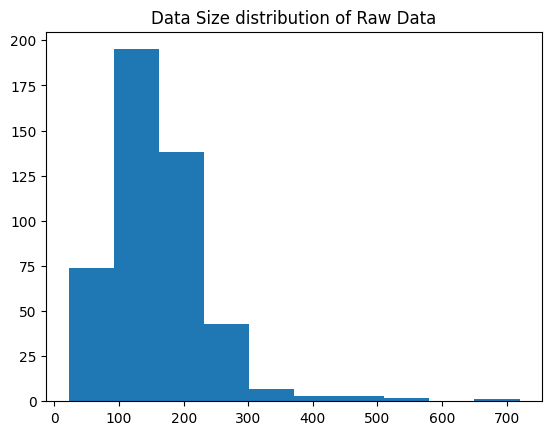

In [5]:
# Block 5: Plot the raw data and frequency distribution 

plt.hist(n_data['abstract_list_len'])
plt.title('Data Size distribution of Raw Data')

Text(0.5, 1.0, 'Data Size distribution of Processed Data')

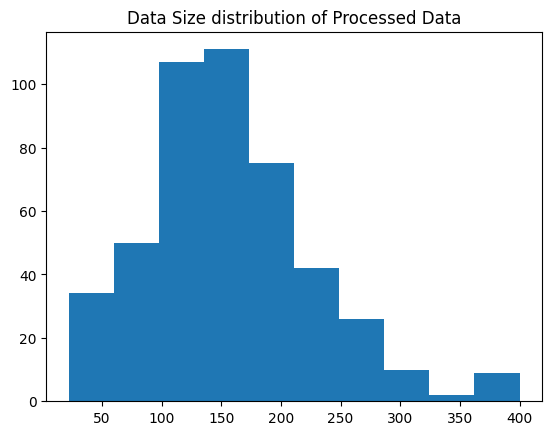

In [6]:
# Block 6: Histogram plot of processed data frequency 

plt.hist(n_data['aabstract_list_trunc_len'])
plt.title('Data Size distribution of Processed Data')

# 5) Cosine SImilarity-

In [7]:
# Block 7: Create custom function for showing the correlation heatmap

def create_similarity_heatmap(corpus_embeddings):
    similarity_matrix = cosine_similarity(corpus_embeddings)
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(11, 9))
    c = sns.heatmap(similarity_matrix, square=True,  ax=ax)
    c.set(xlabel='Document ID', ylabel='Document ID')
    plt.show()
    fig = c.get_figure()
    fig.suptitle('TF-IDF Document Similarity Matrix', fontsize=25)

# 6) Clustering 

## 6.a) Elbow Plot

In [8]:
# Block 8: Plot elbow method to find number of clusters

def plot_elbow_method(embedding):
  
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(embedding)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

## 6.b) PCA and Kmeans

In [9]:
# Block 9: Initialize the cluster function and dimensionality reduction function

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def get_cluster_kmeans(vectorize, num_clusters, r_state=100):
    km = KMeans(n_clusters = num_clusters, random_state=r_state )
    km.fit(vectorize)
    cluster_list = km.labels_.tolist()
    return cluster_list

def pca_reduction(similarity_matrix, n_components):
    one_min_sim = 1 - similarity_matrix
    pca = PCA(n_components=10)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 1]
    return (x_pos, y_pos)

## 6.c) Plotting Scatter plot -2D

In [10]:
# Block 10: 2D scatter plot of clustering results

def plot_graph(clusters, umap_data):
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters
    plt.figure(figsize=(10,10))
    sns.scatterplot(
        x="x", y="y",
        hue="labels",
        palette='Spectral',
        data=result,
        legend="full"
    )

# 7) Mean S-BERT Encode 

## 7.a) Initiating the model

In [11]:
# Block 11: Initiate the model

from transformers import AutoTokenizer, AutoModel
import torch


#Sentences we want sentence embeddings for
sentences = list(n_data['final_text'].values) 

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=300, return_tensors='pt')


In [12]:
# Block 12: Mean pooling take attention mask into account for correct averaging

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [13]:
# Block 13: Sentences we want sentence embeddings for

sentences = list(n_data['final_text'].values) 

In [14]:
#Block 14: Sentences we want sentence embeddings for

sentences = list(n_data['final_text'].values) 

In [15]:
#Block 15: Load AutoModel from huggingface model repository

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")


In [16]:
#Block 16: Tokenize sentences

encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=300, return_tensors='pt')


In [17]:
#Block 17: Compute token embeddings

with torch.no_grad():
  model_output = model(**encoded_input)

In [18]:
# Block 18: compute the mean-pooled embeddings

not path.exists("/content/s_bert.csv")
import csv
if not path.exists("/content/s_bert.csv"):
    with open('/content/s_bert.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for sentence in n_data['final_text'].values:
            encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=450, return_tensors='pt')
            with torch.no_grad():
                model_output = model(**encoded_input)
            writer.writerow(mean_pooling(model_output, encoded_input['attention_mask']))

In [19]:
# Block 19: Process SBERT embeddings for clustering

df_sbert = pd.read_csv('/content/s_bert.csv',header=None)
s_bert_list =[]
for i in df_sbert[0]:
    s_bert_list.append([float(j) for j in i.replace('\n','').replace('tensor(','').replace(')','').replace('[','').replace(']','').split(',')])

In [20]:
# Block 20: sentence embeddings from the pre-trained s_bert_model

sentence_embeddings_df = pd.DataFrame(s_bert_list)
sentence_embeddings = np.array(sentence_embeddings_df)

## 7.c) Plotting the similarity Matrix

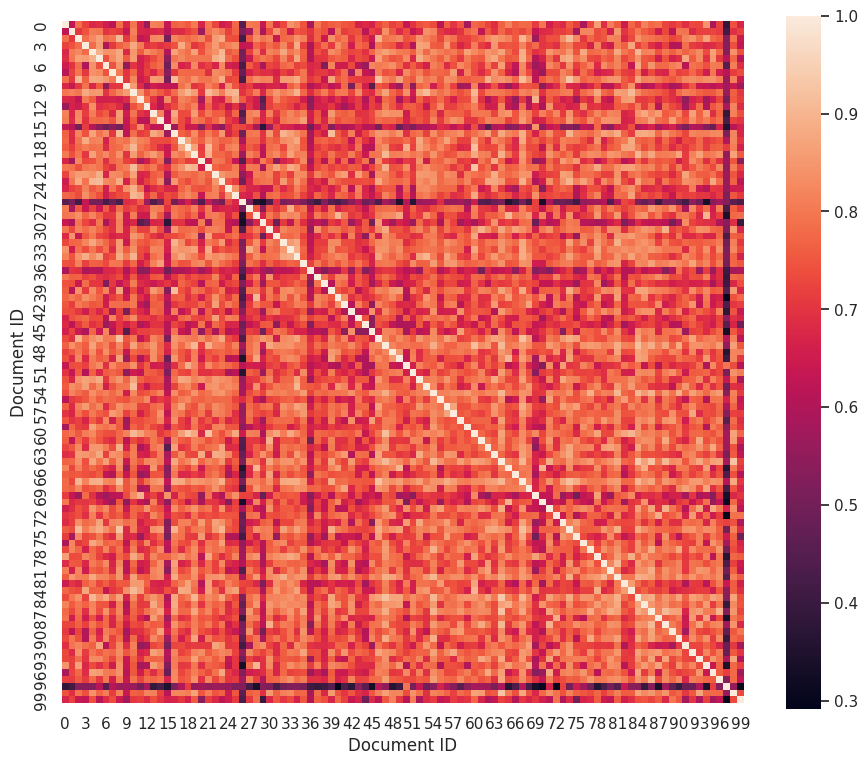

In [21]:
# Block 21: Correlation Heatmap 

create_similarity_heatmap(sentence_embeddings[100:200,100:200])

### 7.c) KMeans Implementation

### Elbow Method to estimate # of  clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

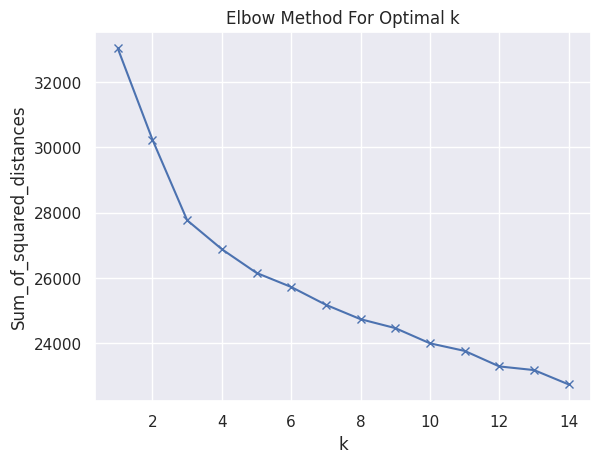

In [22]:
# Block 22: Elbow method to find number of clusters

plot_elbow_method(sentence_embeddings)

### PCA plot with KMEANS

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


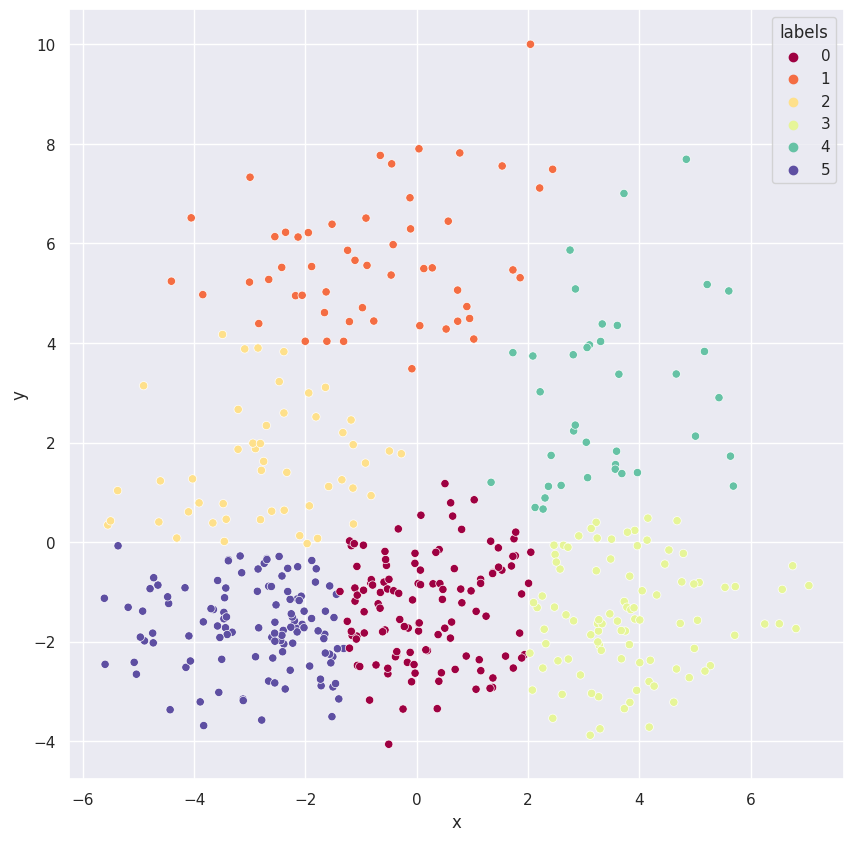

In [23]:
# Block 23: PCA plot with K means

number_of_clusters = 6
x_pos, y_pos = pca_reduction(sentence_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_s_bert = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_s_bert, df)

# 8) Bert Base Implementation - Last Hidden State


## 8.a) Reading weights for bert Base

In [24]:
# Block 24: Reading weights for BERT base

try: 
    df_bbw = pd.read_csv('/content/Bert_base_weights.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(768):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

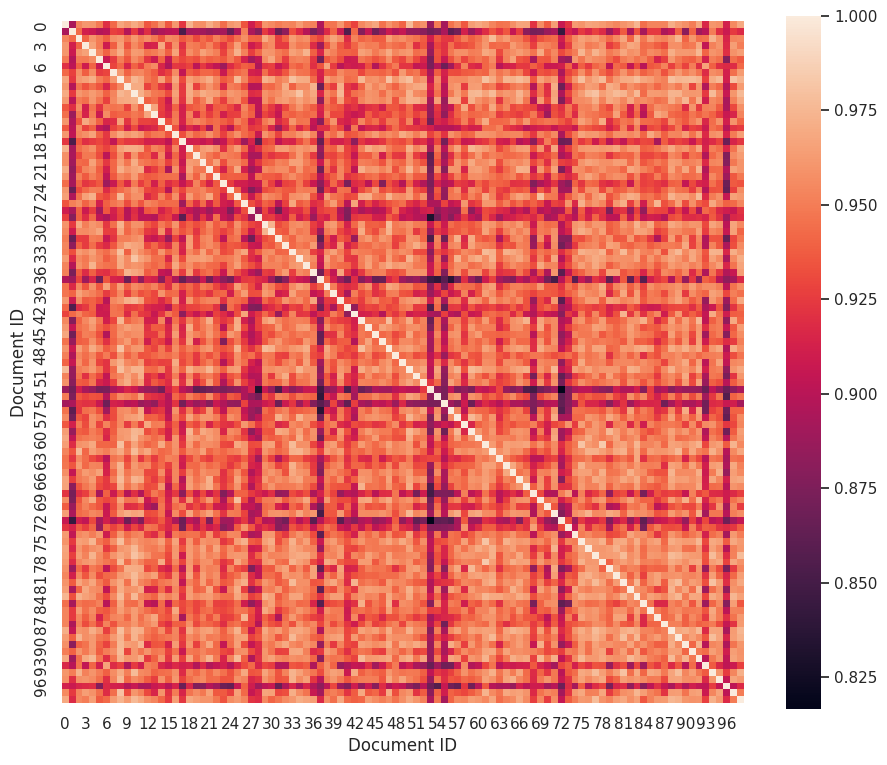

In [25]:
# Block 25: Cosine similarity heatmap

create_similarity_heatmap(bert_base_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

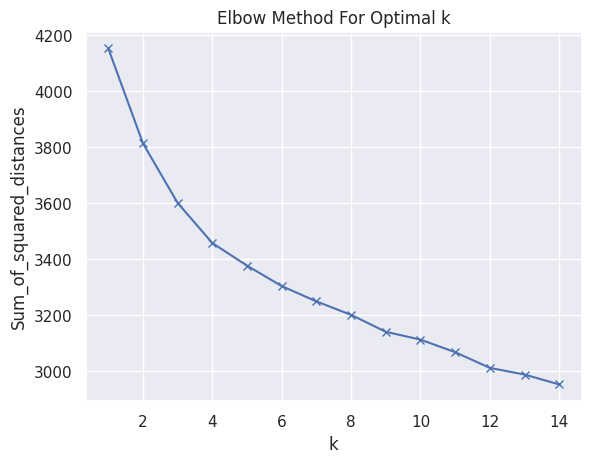

In [26]:
# Block 26: elbow method to get number of clusters

plot_elbow_method(bert_base_embeddings)

### PCA plot with KMEANS

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


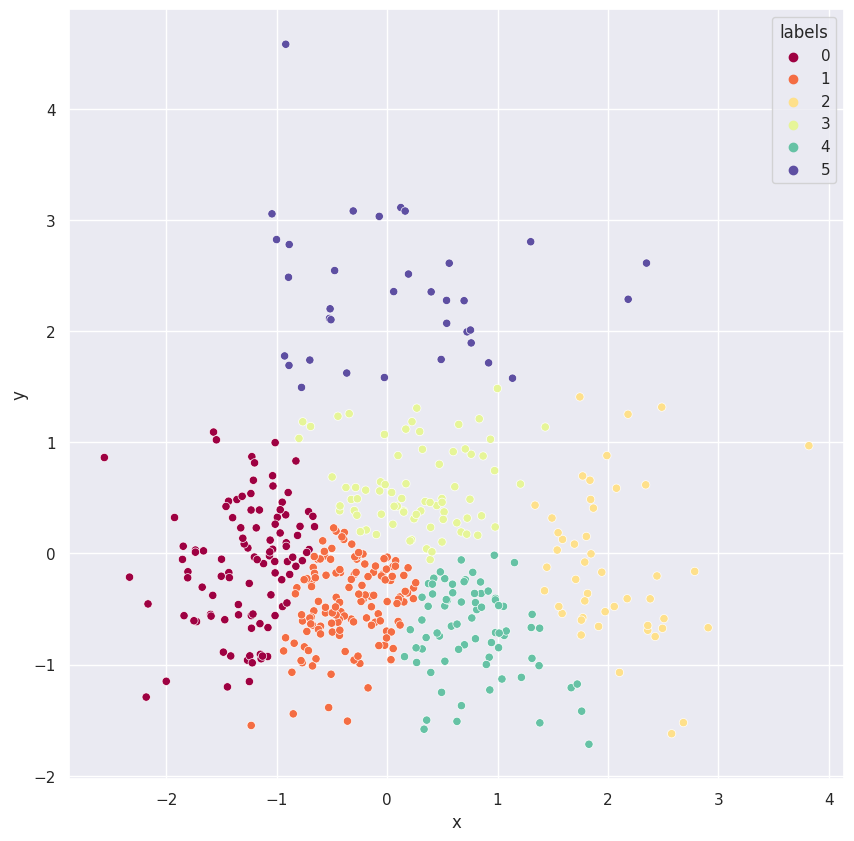

In [27]:
# Block 27: PCA plot with K means

number_of_clusters = 6
x_pos, y_pos = pca_reduction(bert_base_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_base, df)

In [28]:
# Block 28: Store the values in Bert Base Cluster

n_data['bert_base_cluster'] = km_clusters_bert_base

# 10) Bert Base Implementation - concat last four Last Hidden State


## 8.a) Reading weights for bert Base

In [29]:
# Block 29: Reading weights for BERT base

try: 
    df_bbw = pd.read_csv('/content/last_four_layer_cat.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(3072):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_fc_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

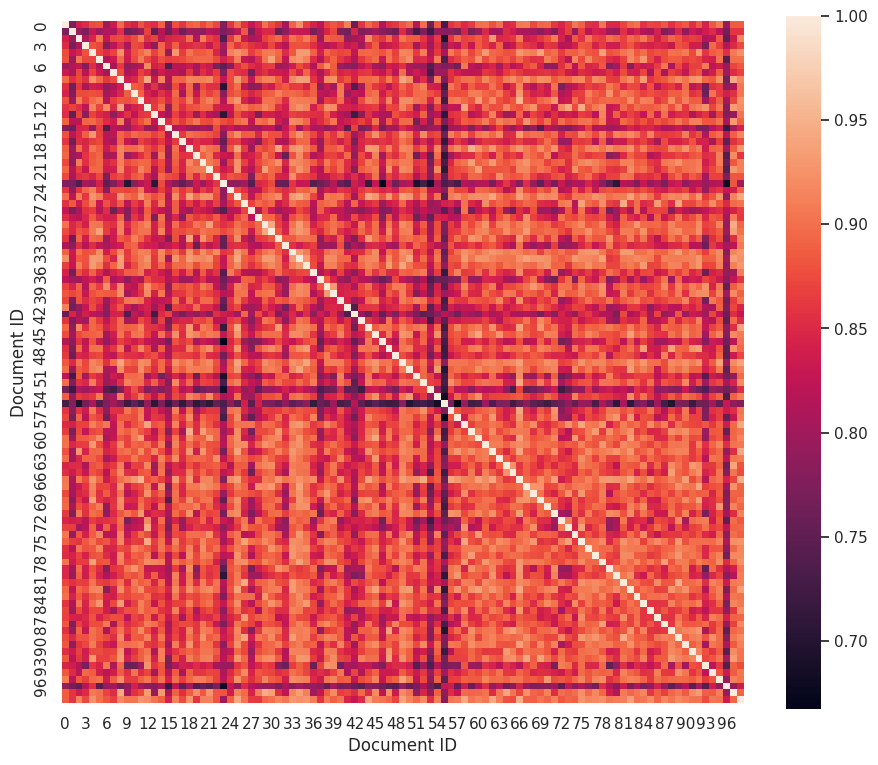

In [30]:
# Block 30: Cosine similarity heatmap

create_similarity_heatmap(bert_base_fc_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

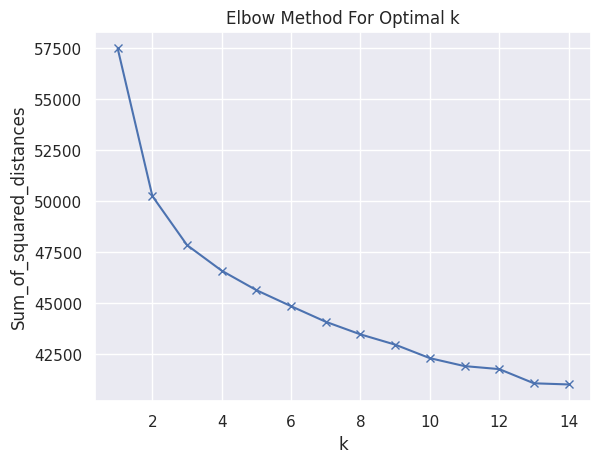

In [31]:
# Block 31: elbow method to get number of clusters

plot_elbow_method(bert_base_fc_embeddings)

### PCA plot with KMEANS

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


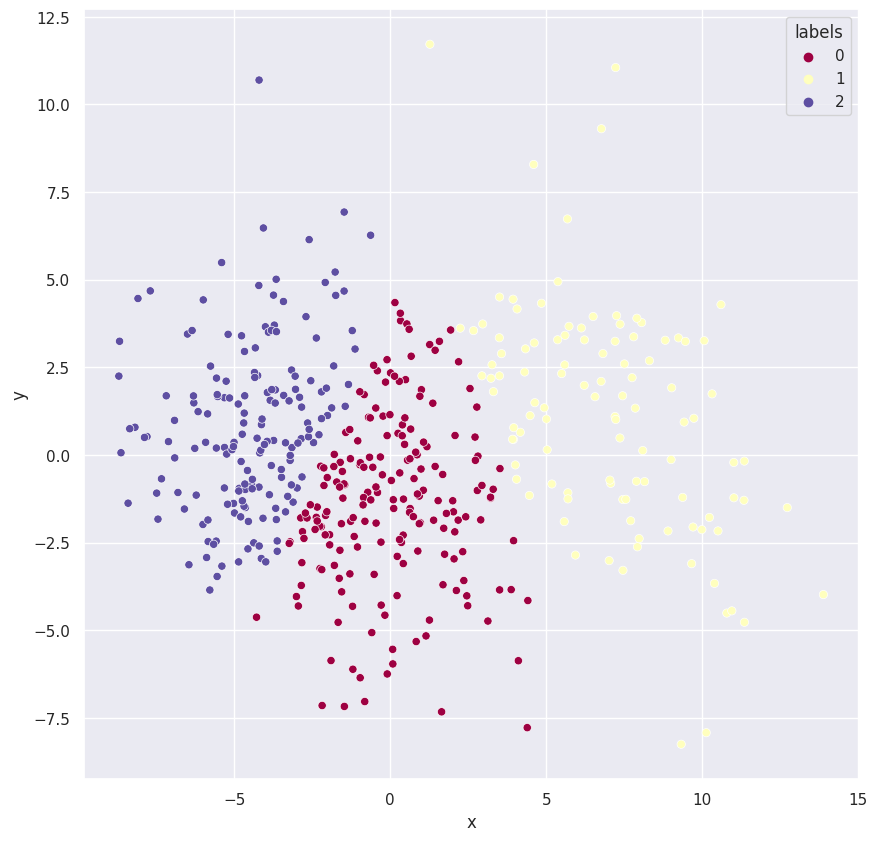

In [32]:
# Block 32: PCA plot with K means

number_of_clusters = 3
x_pos, y_pos = pca_reduction(bert_base_fc_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_fc_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_fc_base, df)

In [33]:
# Block 33: Store the values in Bert Base Cluster

n_data['km_clusters_bert_fc_base'] = km_clusters_bert_fc_base

# 11) Mean Bert Base Implementation


## 8.a) Reading weights for bert Base

In [34]:
# Block 34: Reading weights for BERT base

try: 
    df_bbw = pd.read_csv('/content/mean_bert_base.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(768):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_mean_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

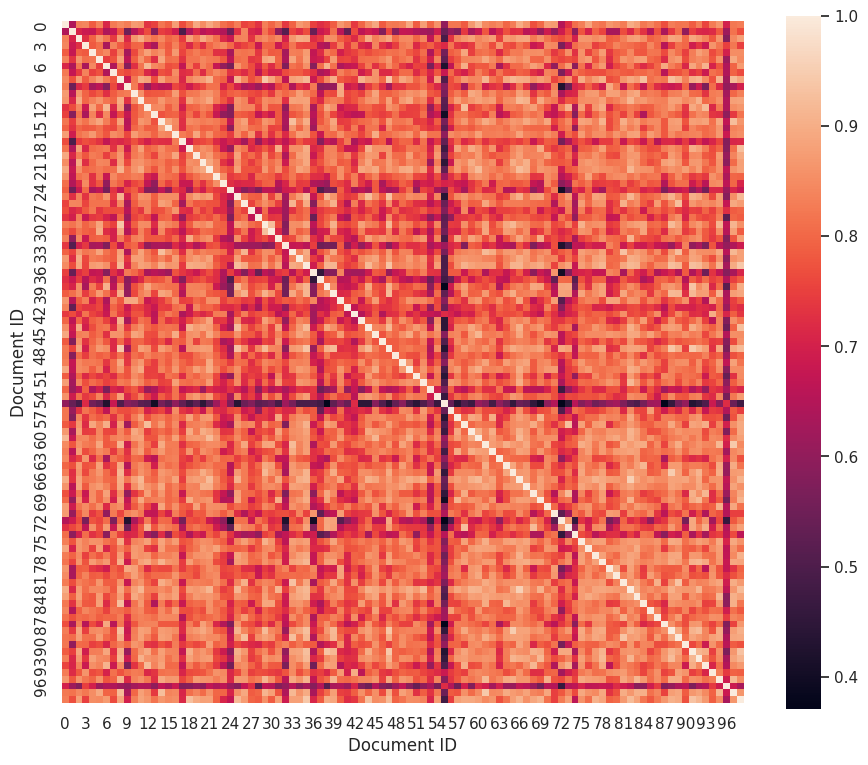

In [35]:
# Block 35: Cosine similarity heatmap

create_similarity_heatmap(bert_base_mean_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

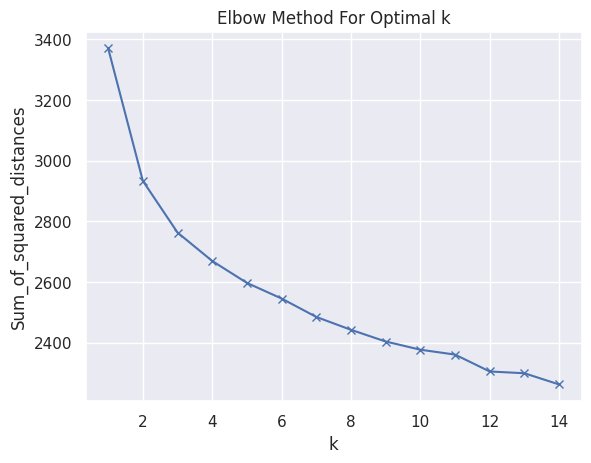

In [36]:
# Block 36: elbow method to get number of clusters

plot_elbow_method(bert_base_mean_embeddings)

### PCA plot with KMEANS

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


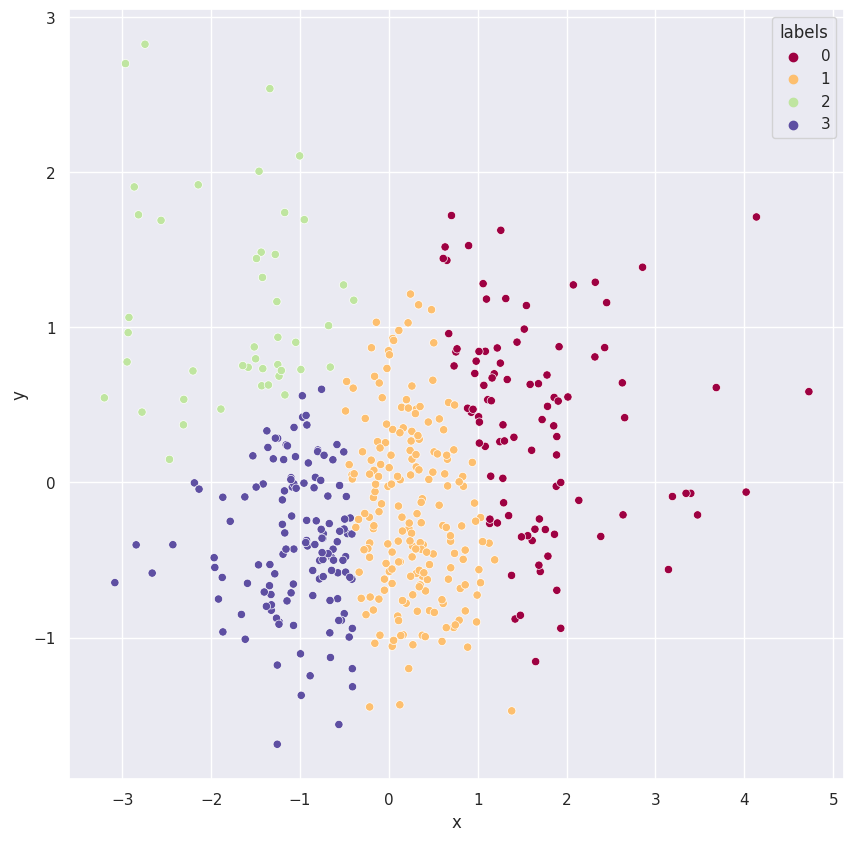

In [37]:
# Block 37: PCA plot with K means

# number_of_clusters = 8
# km_clusters_bert_base = get_cluster_kmeans(bert_base_embeddings, number_of_clusters) # 466 X 768 
# x_pos, y_pos = pca_reduction(bert_base_embeddings, 2)
# scatter_clusters(x_pos, y_pos, km_clusters_bert_base)

number_of_clusters = 4 
x_pos, y_pos = pca_reduction(bert_base_mean_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_mean_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_mean_base, df)

In [38]:
# Block 38: Store the values in Bert Base Cluster

n_data['km_clusters_bert_mean_base'] = km_clusters_bert_mean_base

In [39]:
# Block 39: Save the file to output_file.csv 

import os
if not os.path.exists('data'):
  os.makedirs('data')
n_data.to_csv('data/output_file.csv')
